Histogram of Oriented Gradients (HOG)

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle

In [2]:
def display_images(images, rows = 1, titles = None, is_gray = False):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        image = np.array(image)
        a = fig.add_subplot(rows, np.ceil(n_images/float(rows)), n + 1)
        if is_gray or len(image.shape) == 2:
            image = image.reshape(image.shape[:2])
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [3]:
vehicles_paths      = glob.glob('dataset/vehicles/**/*.png')
non_vehicles_paths  = glob.glob('dataset/non-vehicles/**/*.png')

def read_images(image_paths):
    return [cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)  for path in image_paths]

vehicles_images = read_images(vehicles_paths)
non_vehicles_images = read_images(non_vehicles_paths)

In [4]:
print(len(vehicles_images))

8792


In [5]:
print(len(non_vehicles_images))

8968


In [6]:
shuffled_images = list(zip(vehicles_images, non_vehicles_images))
np.random.shuffle(shuffled_images)
shuffled_images = [j for i in shuffled_images for j in i]

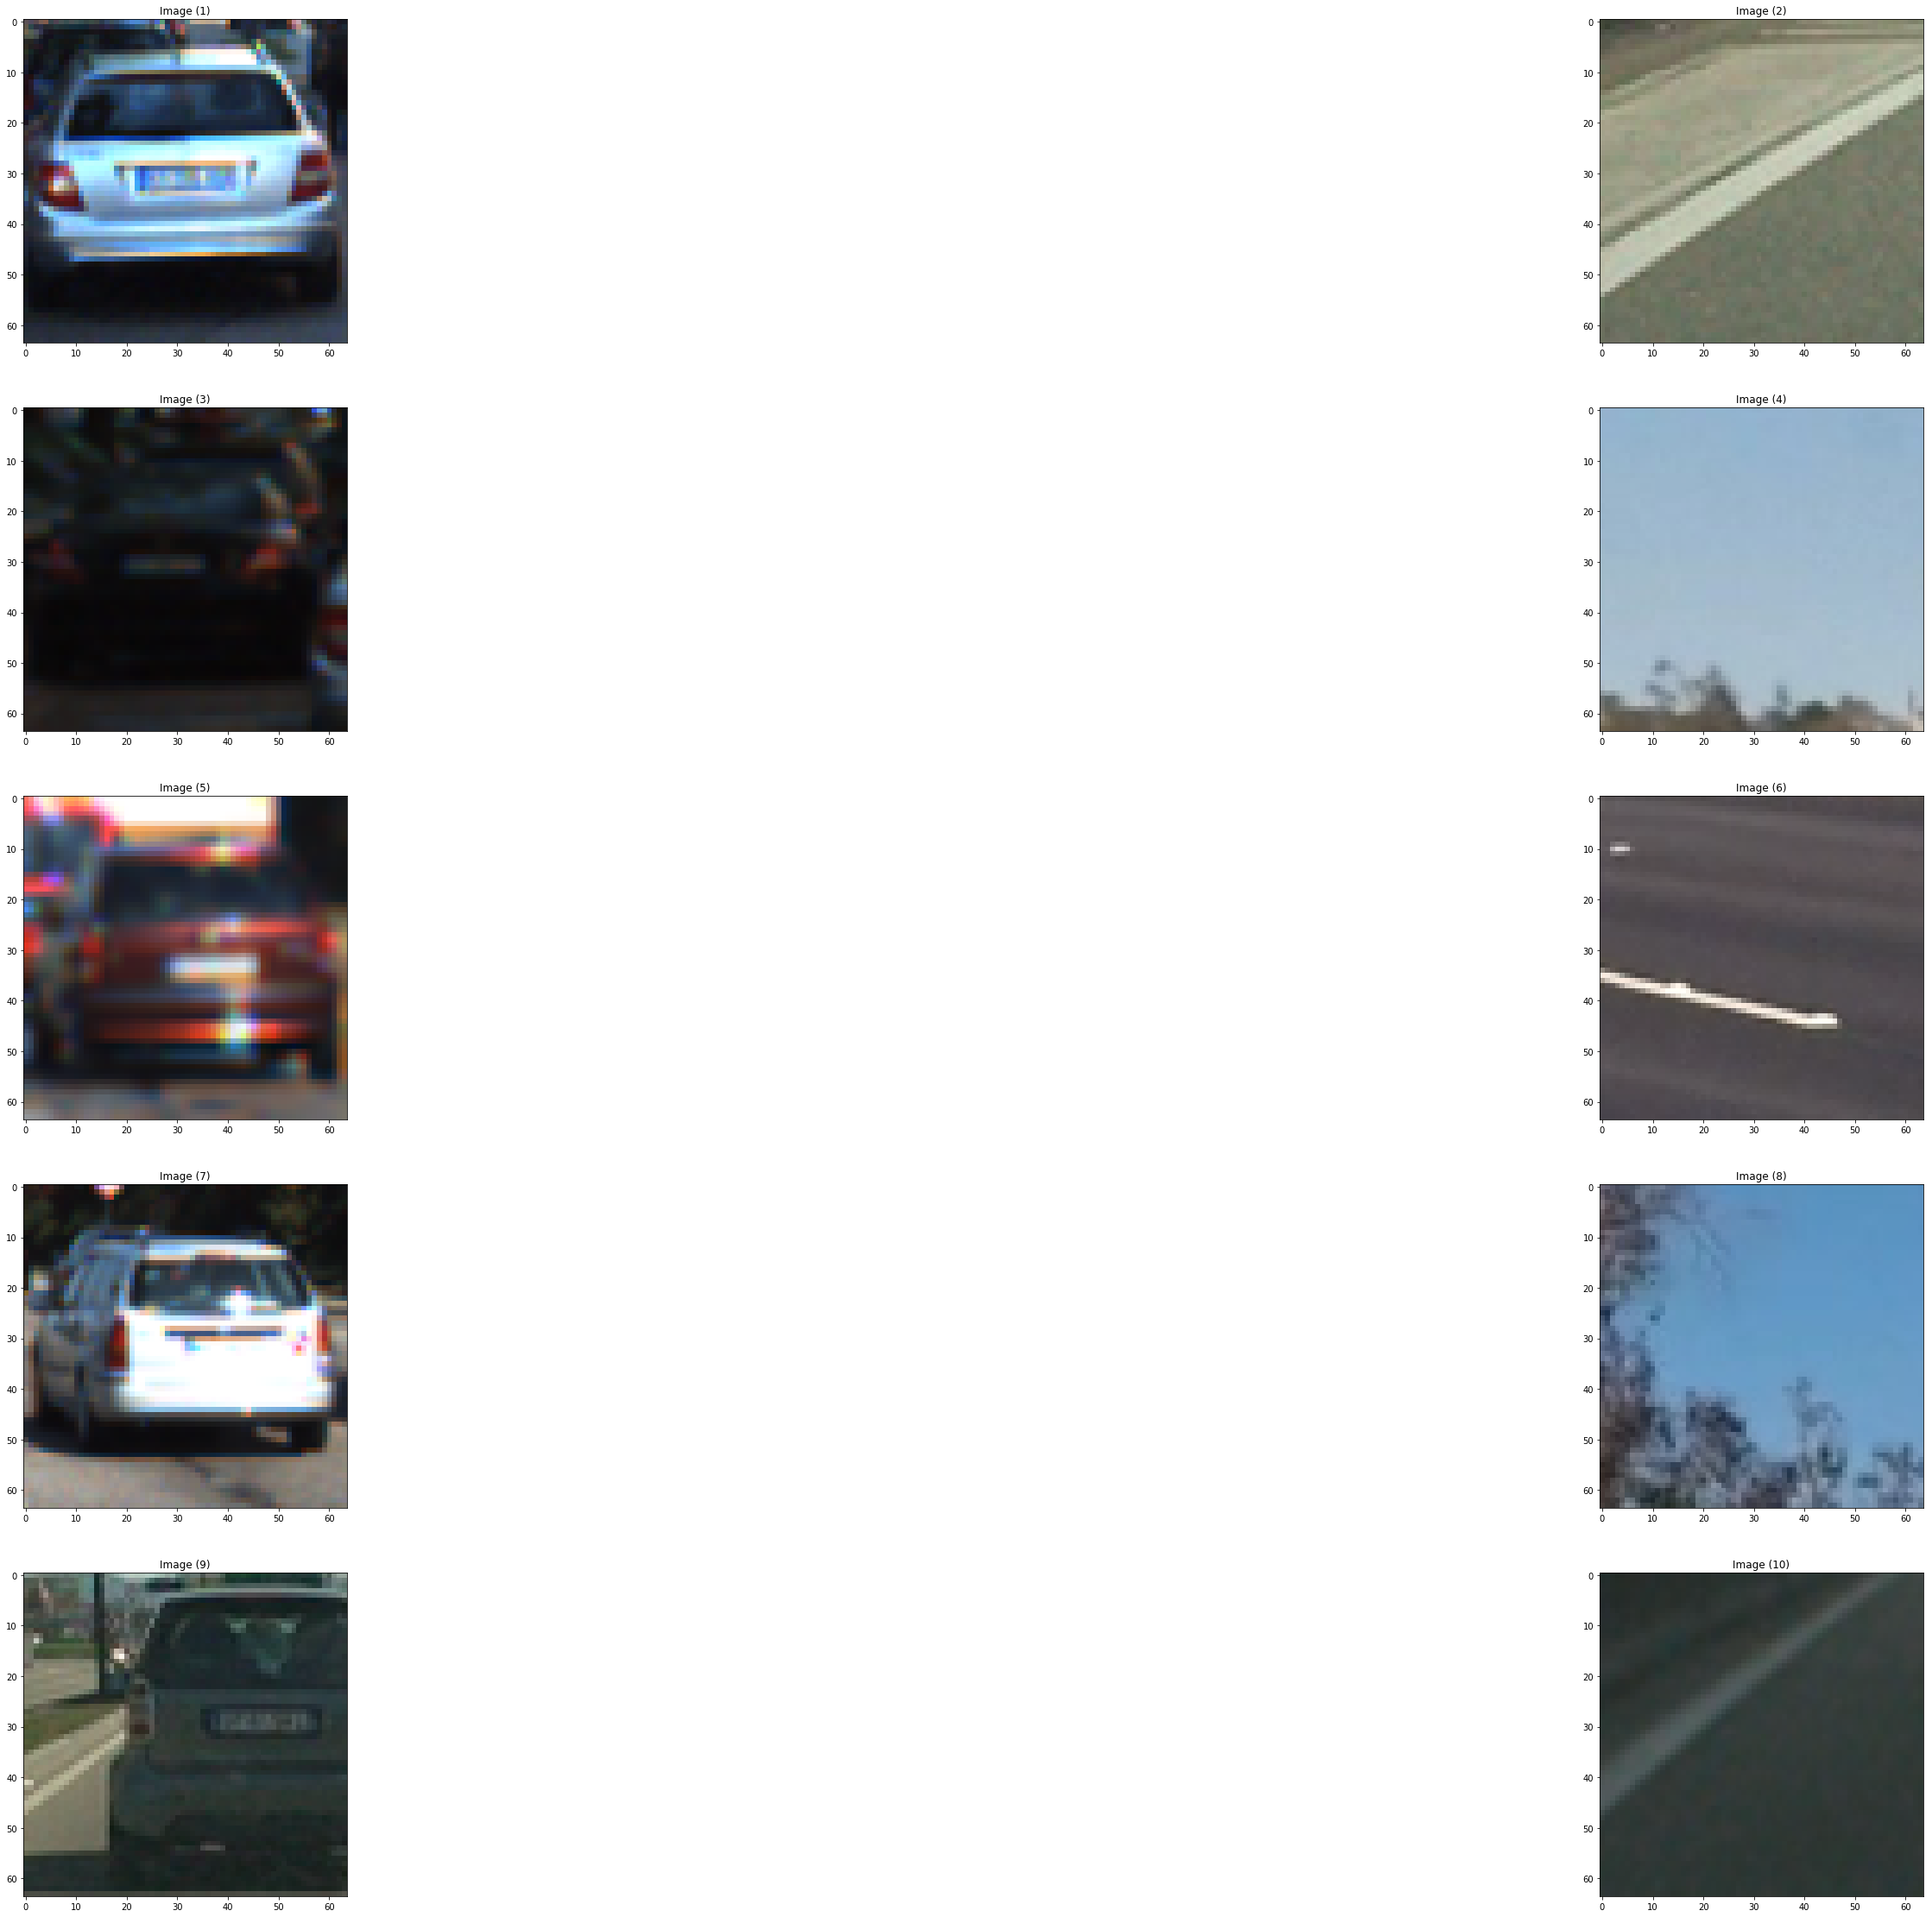

In [7]:
display_images(shuffled_images[:10],5)

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs: 
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features



/Users/romkof/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
def test_feature_extraction(colorspace, orient, pix_per_cell, cell_per_block, hog_channel):
    t=time.time()
    car_features = extract_features(vehicles_images, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    notcar_features = extract_features(non_vehicles_images, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    t2 = time.time()
    extraction_time = round(t2-t, 2)
    print(extraction_time, 'Seconds to extract HOG features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    feature_length = len(X_train[0])
    print('Feature vector length:', feature_length)
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    train_svc_time = round(t2-t, 2)
    print(train_svc_time, 'Seconds to train SVC...')
    # Check the score of the SVC
    test_accurancy = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', test_accurancy)
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    prediction_time = round(t2-t, 5)
    print(prediction_time , 'Seconds to predict', n_predict,'labels with SVC')
    print(".............")
    return extraction_time, feature_length, train_svc_time, test_accurancy, prediction_time

In [11]:
from sklearn.model_selection import ParameterGrid

In [14]:
param_grid = {'colorspace':    ['HSV', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'],
              'orient' :       [9, 11],
              'pix_per_cell':  [4, 8],
              'cell_per_block':[1, 2],
              'hog_channel':   [0, 1, 2, 'ALL']}

grid = ParameterGrid(param_grid)

#for params in grid:
#    your_function(params['param1'], params['param2'])

In [15]:
t=time.time()
feature_extraction_restult = {}
for index, params in enumerate(grid):
    print('test feature extraction ', index, ' of ', len(grid)-1)
    extraction_time, feature_length, train_svc_time, test_accurancy, prediction_time = test_feature_extraction(params['colorspace'], params['orient'], params['pix_per_cell'], params['cell_per_block'], params['hog_channel'])

    feature_extraction_restult.setdefault('colorspace', [])
    feature_extraction_restult['colorspace'].append(params['colorspace'])
    
    feature_extraction_restult.setdefault('orient', [])
    feature_extraction_restult['orient'].append(params['orient'])
    
    feature_extraction_restult.setdefault('pix_per_cell', [])
    feature_extraction_restult['pix_per_cell'].append(params['pix_per_cell'])
    
    feature_extraction_restult.setdefault('cell_per_block', [])
    feature_extraction_restult['cell_per_block'].append(params['cell_per_block'])
    
    feature_extraction_restult.setdefault('hog_channel', [])
    feature_extraction_restult['hog_channel'].append(params['hog_channel'])
    
    feature_extraction_restult.setdefault('extraction_time', [])
    feature_extraction_restult['extraction_time'].append(extraction_time)
    
    feature_extraction_restult.setdefault('feature_length', [])
    feature_extraction_restult['feature_length'].append(feature_length)
    
    feature_extraction_restult.setdefault('train_svc_time', [])
    feature_extraction_restult['train_svc_time'].append(train_svc_time)
    
    feature_extraction_restult.setdefault('test_accurancy', [])
    feature_extraction_restult['test_accurancy'].append(test_accurancy)
    
    feature_extraction_restult.setdefault('prediction_time', [])
    feature_extraction_restult['prediction_time'].append(prediction_time)
    
       
t2 = time.time()
print(round(t2-t, 2), 'Seconds to test all feature extion combination')

with open('feature_extraction_restult.p', 'wb') as handle:
    pickle.dump(feature_extraction_restult, handle, protocol=pickle.HIGHEST_PROTOCOL)


test feature extraction  0  of  191
193.52 Seconds to extract HOG features...
Using: 9 orientations 4 pixels per cell and 1 cells per block
Feature vector length: 2304
27.46 Seconds to train SVC...
Test Accuracy of SVC =  0.8387
My SVC predicts:  [ 1.  1.  0.  1.  0.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  1.  1.  0.  0.]
0.00152 Seconds to predict 10 labels with SVC
.............
test feature extraction  1  of  191
59.03 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 576
13.45 Seconds to train SVC...
Test Accuracy of SVC =  0.8891
My SVC predicts:  [ 1.  0.  1.  1.  0.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  0.  0.  1.  0.  0.  0.]
0.00146 Seconds to predict 10 labels with SVC
.............
test feature extraction  2  of  191
191.22 Seconds to extract HOG features...
Using: 11 orientations 4 pixels per cell and 1 cells per block
Feature vector length: 2816
26.11 S

189.96 Seconds to extract HOG features...
Using: 9 orientations 4 pixels per cell and 1 cells per block
Feature vector length: 2304
24.73 Seconds to train SVC...
Test Accuracy of SVC =  0.8584
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  1.  1.  0.  1.]
0.00144 Seconds to predict 10 labels with SVC
.............
test feature extraction  21  of  191
58.78 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 576
11.24 Seconds to train SVC...
Test Accuracy of SVC =  0.9096
My SVC predicts:  [ 0.  1.  0.  1.  0.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  1.  1.  0.  0.]
0.00151 Seconds to predict 10 labels with SVC
.............
test feature extraction  22  of  191
190.7 Seconds to extract HOG features...
Using: 11 orientations 4 pixels per cell and 1 cells per block
Feature vector length: 2816
25.02 Seconds to train SVC...
Test Accurac

191.59 Seconds to extract HOG features...
Using: 9 orientations 4 pixels per cell and 1 cells per block
Feature vector length: 2304
37.5 Seconds to train SVC...
Test Accuracy of SVC =  0.8305
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  1.  1.  1.  0.]
0.00148 Seconds to predict 10 labels with SVC
.............
test feature extraction  41  of  191
59.9 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 576
15.63 Seconds to train SVC...
Test Accuracy of SVC =  0.8868
My SVC predicts:  [ 1.  0.  0.  0.  1.  0.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  1.  0.  0.  1.  1.  0.]
0.00147 Seconds to predict 10 labels with SVC
.............
test feature extraction  42  of  191
192.46 Seconds to extract HOG features...
Using: 11 orientations 4 pixels per cell and 1 cells per block
Feature vector length: 2816
19.67 Seconds to train SVC...
Test Accuracy

569.24 Seconds to extract HOG features...
Using: 9 orientations 4 pixels per cell and 1 cells per block
Feature vector length: 6912
50.87 Seconds to train SVC...
Test Accuracy of SVC =  0.9147
My SVC predicts:  [ 0.  0.  1.  1.  0.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  0.  0.  1.  0.  0.]
0.00166 Seconds to predict 10 labels with SVC
.............
test feature extraction  61  of  191
175.13 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 1728
8.83 Seconds to train SVC...
Test Accuracy of SVC =  0.9423
My SVC predicts:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
0.00174 Seconds to predict 10 labels with SVC
.............
test feature extraction  62  of  191
571.99 Seconds to extract HOG features...
Using: 11 orientations 4 pixels per cell and 1 cells per block
Feature vector length: 8448
65.11 Seconds to train SVC...
Test Accur

189.68 Seconds to extract HOG features...
Using: 9 orientations 4 pixels per cell and 1 cells per block
Feature vector length: 2304
39.4 Seconds to train SVC...
Test Accuracy of SVC =  0.8277
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  0.  0.  0.  0.]
0.00144 Seconds to predict 10 labels with SVC
.............
test feature extraction  81  of  191
58.11 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 576
12.93 Seconds to train SVC...
Test Accuracy of SVC =  0.888
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  0.  0.  1.  1.  1.]
0.00144 Seconds to predict 10 labels with SVC
.............
test feature extraction  82  of  191
189.94 Seconds to extract HOG features...
Using: 11 orientations 4 pixels per cell and 1 cells per block
Feature vector length: 2816
35.53 Seconds to train SVC...
Test Accuracy

197.91 Seconds to extract HOG features...
Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 8100
76.92 Seconds to train SVC...
Test Accuracy of SVC =  0.8753
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  0.  1.  1.  0.]
0.00145 Seconds to predict 10 labels with SVC
.............
test feature extraction  101  of  191
54.83 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
18.35 Seconds to train SVC...
Test Accuracy of SVC =  0.9158
My SVC predicts:  [ 0.  1.  1.  0.  1.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
0.00152 Seconds to predict 10 labels with SVC
.............
test feature extraction  102  of  191
199.13 Seconds to extract HOG features...
Using: 11 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 9900
99.88 Seconds to train SVC...
Test Acc

198.06 Seconds to extract HOG features...
Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 8100
72.51 Seconds to train SVC...
Test Accuracy of SVC =  0.8784
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  0.  1.  1.  0.  1.  1.]
0.00377 Seconds to predict 10 labels with SVC
.............
test feature extraction  121  of  191
54.64 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
16.33 Seconds to train SVC...
Test Accuracy of SVC =  0.9195
My SVC predicts:  [ 0.  1.  1.  1.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  1.  1.  0.  0.  0.  0.]
0.00145 Seconds to predict 10 labels with SVC
.............
test feature extraction  122  of  191
199.53 Seconds to extract HOG features...
Using: 11 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 9900
92.64 Seconds to train SVC...
Test Acc

594.0 Seconds to extract HOG features...
Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 24300
17.61 Seconds to train SVC...
Test Accuracy of SVC =  0.96
My SVC predicts:  [ 0.  1.  1.  0.  1.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  0.  0.  0.  0.]
0.00589 Seconds to predict 10 labels with SVC
.............
test feature extraction  141  of  191
165.14 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
19.09 Seconds to train SVC...
Test Accuracy of SVC =  0.9673
My SVC predicts:  [ 1.  1.  0.  1.  1.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  1.  1.  1.  1.  1.  0.]
0.00158 Seconds to predict 10 labels with SVC
.............
test feature extraction  142  of  191
596.1 Seconds to extract HOG features...
Using: 11 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 29700
33.28 Seconds to train SVC...
Test Accu

test feature extraction  160  of  191
197.37 Seconds to extract HOG features...
Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 8100
72.11 Seconds to train SVC...
Test Accuracy of SVC =  0.8801
My SVC predicts:  [ 1.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.]
0.00147 Seconds to predict 10 labels with SVC
.............
test feature extraction  161  of  191
54.18 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
16.17 Seconds to train SVC...
Test Accuracy of SVC =  0.9116
My SVC predicts:  [ 1.  1.  0.  0.  1.  0.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  1.  0.  1.  1.  1.  1.]
0.00164 Seconds to predict 10 labels with SVC
.............
test feature extraction  162  of  191
199.02 Seconds to extract HOG features...
Using: 11 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 9900


197.92 Seconds to extract HOG features...
Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 8100
49.48 Seconds to train SVC...
Test Accuracy of SVC =  0.9093
My SVC predicts:  [ 1.  0.  1.  1.  1.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  0.  1.  1.  1.]
0.00157 Seconds to predict 10 labels with SVC
.............
test feature extraction  181  of  191
54.22 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
12.02 Seconds to train SVC...
Test Accuracy of SVC =  0.9102
My SVC predicts:  [ 0.  0.  1.  1.  0.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  0.  0.  1.  0.  0.]
0.00153 Seconds to predict 10 labels with SVC
.............
test feature extraction  182  of  191
198.73 Seconds to extract HOG features...
Using: 11 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 9900
71.02 Seconds to train SVC...
Test Acc

In [30]:
import pandas as pd
feature_extraction_df =  pd.DataFrame(feature_extraction_restult)
feature_extraction_df.sort_values(by=['test_accurancy'], ascending=False)

,cell_per_block,colorspace,extraction_time,feature_length,hog_channel,orient,pix_per_cell,prediction_time,test_accurancy,train_svc_time
174,2,YUV,599.50,29700,ALL,11,4,0.00582,0.9738,19.78
94,1,YCrCb,572.30,8448,ALL,11,4,0.00139,0.9710,51.24
188,2,YCrCb,594.25,24300,ALL,9,4,0.00261,0.9702,158.15
143,2,LUV,168.99,6468,ALL,11,8,0.00147,0.9693,23.84
191,2,YCrCb,164.69,6468,ALL,11,8,0.00147,0.9690,23.96
190,2,YCrCb,598.12,29700,ALL,11,4,0.00336,0.9690,37.98
173,2,YUV,164.22,5292,ALL,9,8,0.00165,0.9679,19.75
175,2,YUV,165.72,6468,ALL,11,8,0.00182,0.9679,24.63
141,2,LUV,165.14,5292,ALL,9,8,0.00158,0.9673,19.09
189,2,YCrCb,163.65,5292,ALL,9,8,0.00150,0.9637,18.95


In [86]:
colorspace = 'YCrCb' 
orient = 11
pix_per_cell = 4
cell_per_block = 1
hog_channel = "ALL"

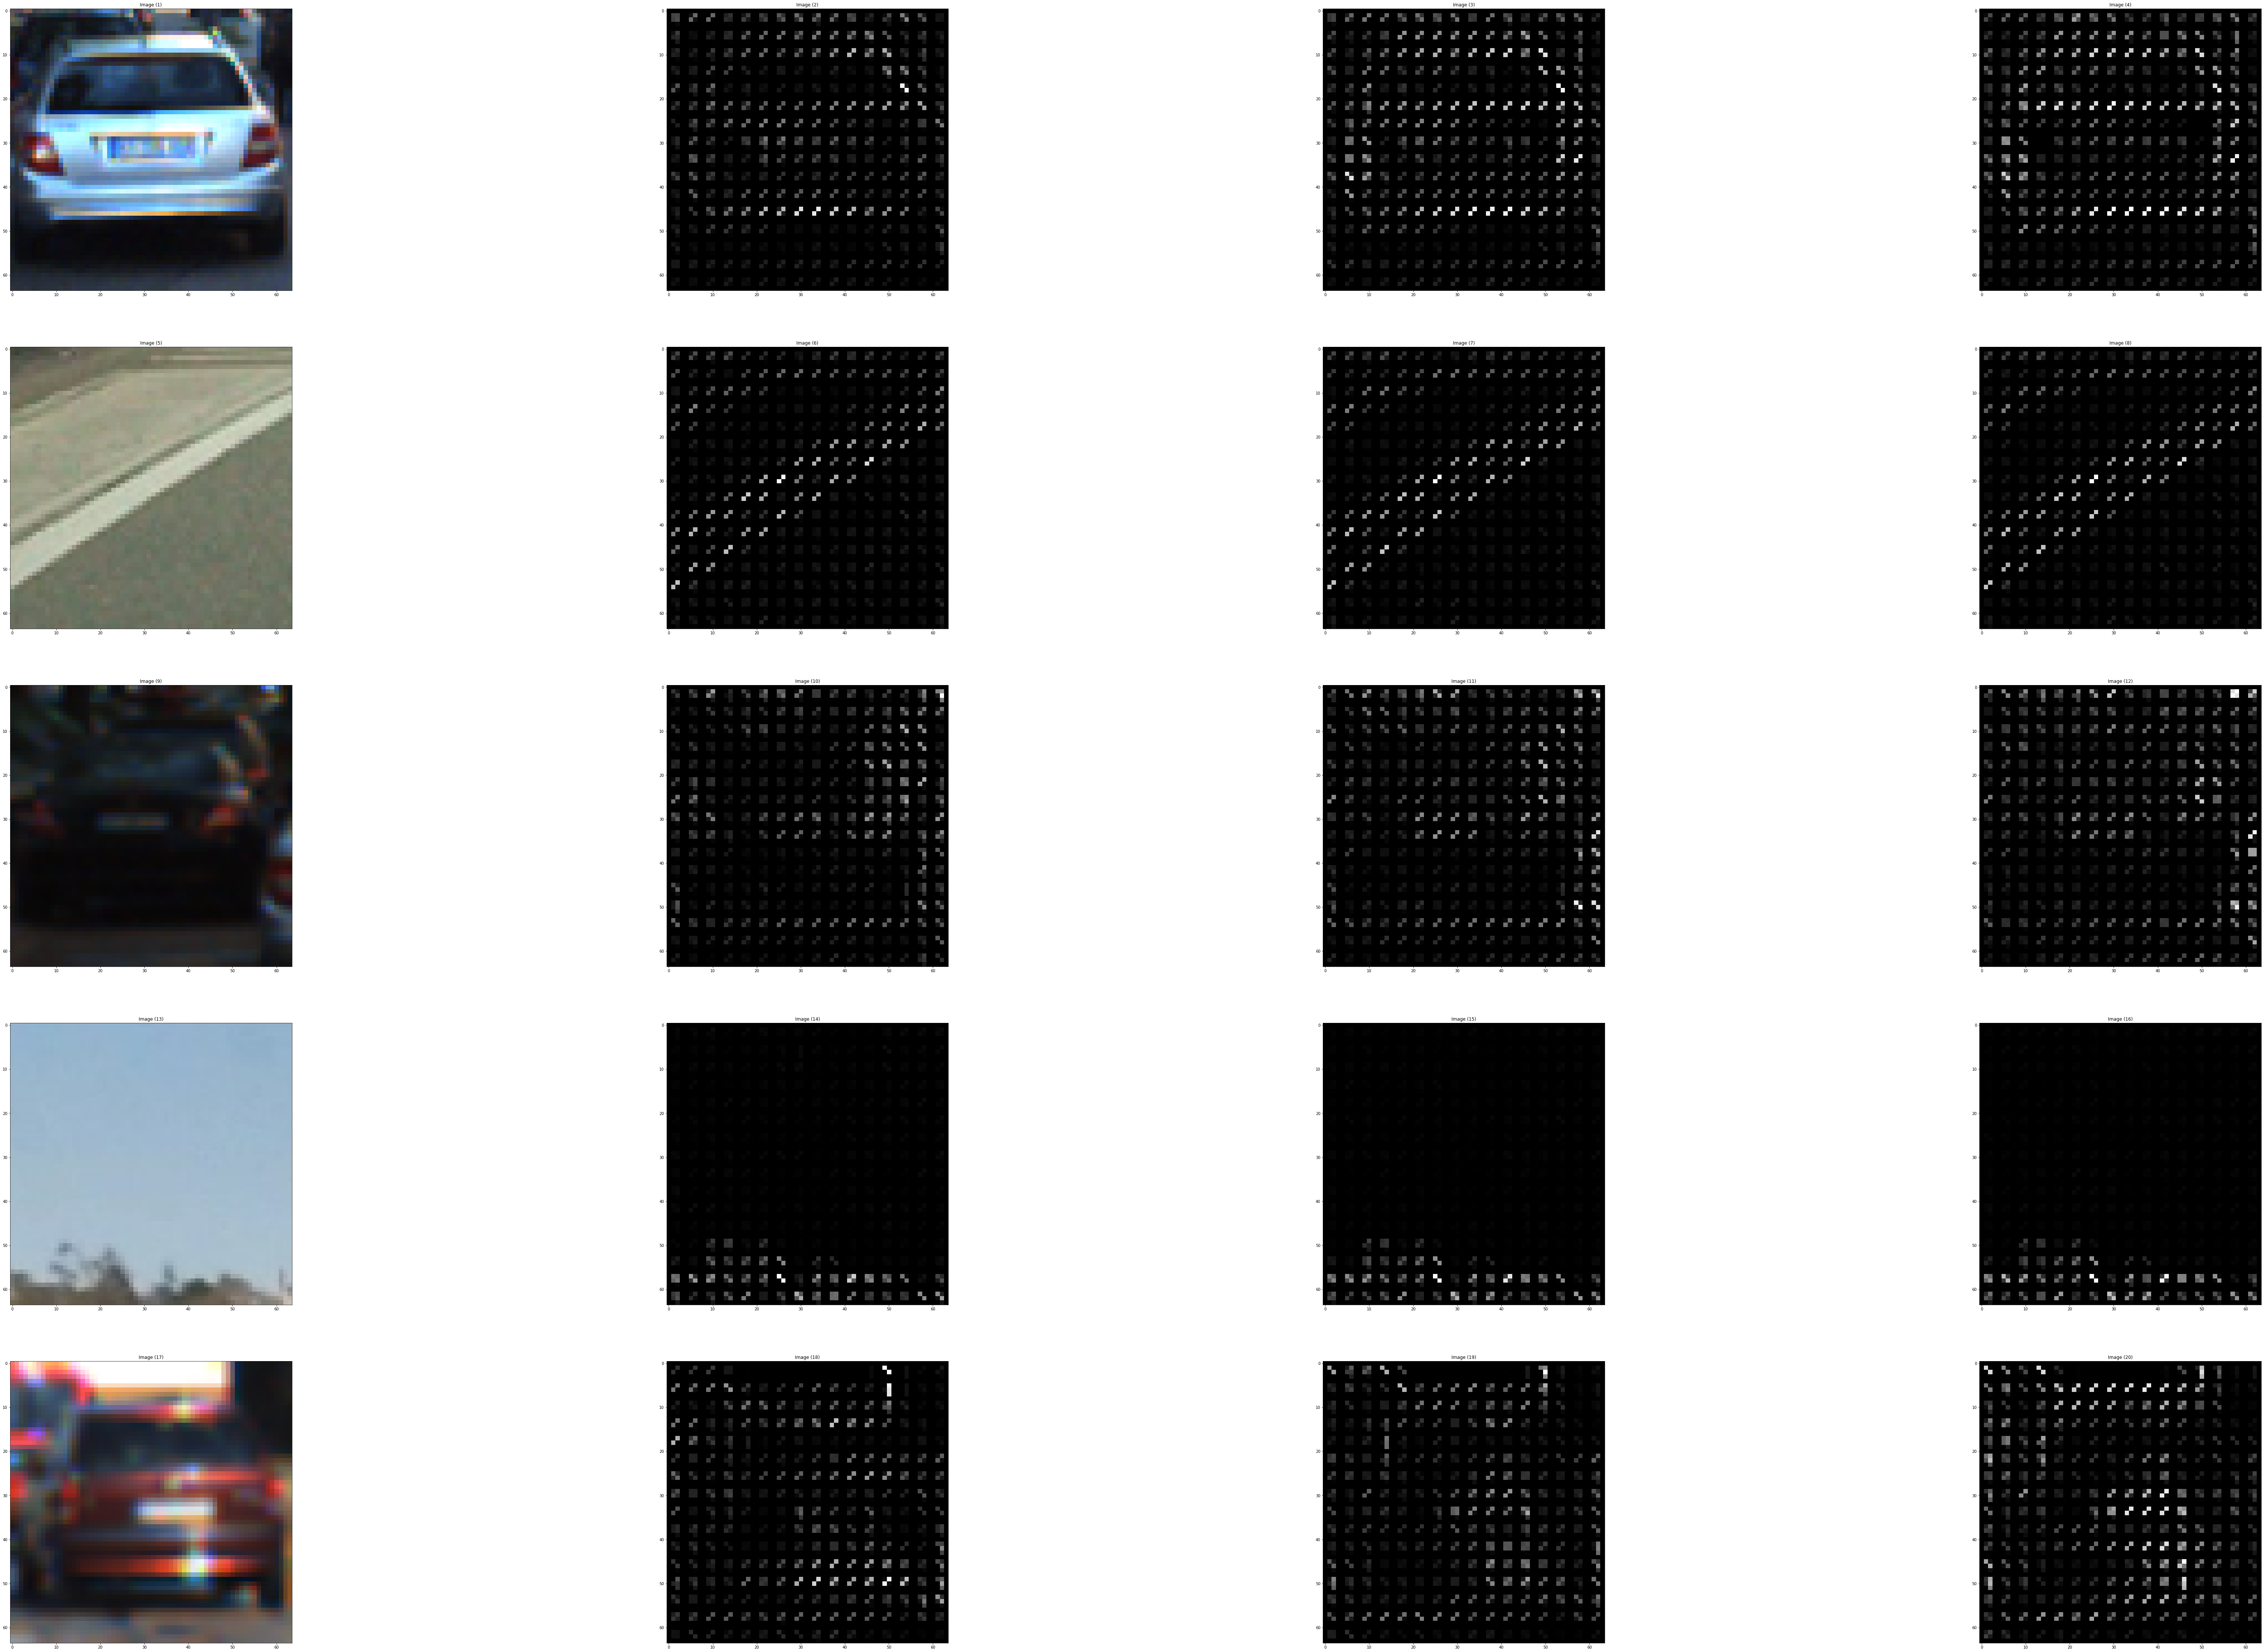

In [87]:
hog_images = []
for img in shuffled_images[:5]:
    hog_channels = []
    for channel in range(img.shape[2]):
        _, hog_img = get_hog_features(img[:,:,channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        hog_channels.append(hog_img)
    hog_images.append(hog_channels)

original_vs_hog = []
for i,j in zip(shuffled_images[:5], hog_images):
    original_vs_hog.append(i)
    original_vs_hog.extend(j)

display_images(original_vs_hog, 5)

In [97]:
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 600] # Min and max in y to search in slide_window()

In [98]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [99]:
car_features = extract_features(vehicles_images, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_vehicles_images, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 11 orientations 4 pixels per cell and 1 cells per block
Feature vector length: 9264
5.66 Seconds to train SVC...
Test Accuracy of SVC =  0.9825


In [100]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

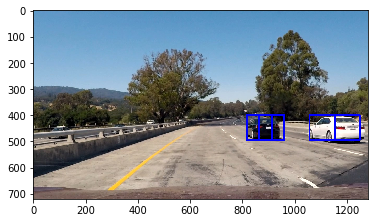

In [145]:
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


In [166]:
def convert_to_colorspace(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: return np.copy(img)
            
def find_cars(img, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, debug=False):
    predicted_windows = []
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_to_colorspace(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or debug:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                predicted_windows.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)]) 
                
    return predicted_windows

In [226]:
def draw_car_boxes(image, colorspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, debug=False):
    
    predicted_windows = []

    ystart = 300
    ystop = 450
    scale = 1.0
    #predicted_windows.extend(find_cars(image, colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,debug = debug))

    ystart = 350
    ystop = 450
    scale = 2.0
    #predicted_windows.extend(find_cars(image, colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,debug = debug))

    ystart = 450
    ystop = 750
    scale = 2.0
    predicted_windows.extend(find_cars(image, colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,debug = debug))

    out_img = np.copy(image)
    for box in predicted_windows:
        cv2.rectangle(out_img,box[0],box[1],(0,0,255),6) 
    display_images([out_img])

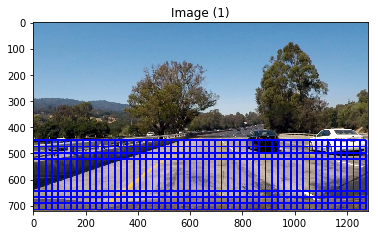

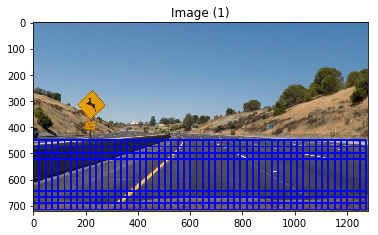

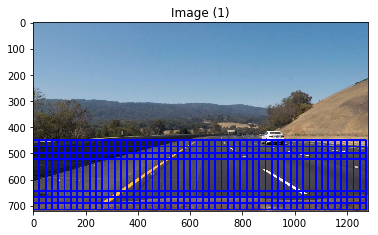

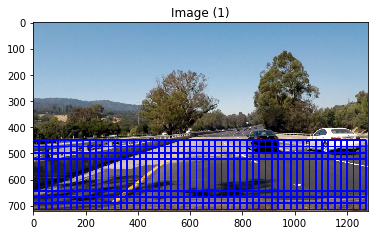

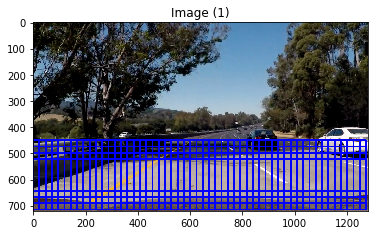

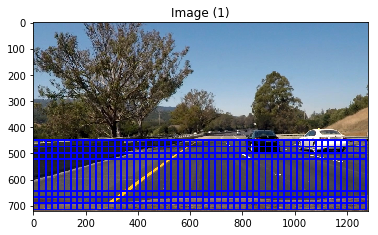

In [227]:
debug=True
image = mpimg.imread('test_images/test1.jpg')
draw_car_boxes(image, colorspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,debug = debug)

image = mpimg.imread('test_images/test2.jpg')
draw_car_boxes(image, colorspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,debug = debug)

image = mpimg.imread('test_images/test3.jpg')
draw_car_boxes(image, colorspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,debug = debug)

image = mpimg.imread('test_images/test4.jpg')
draw_car_boxes(image, colorspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,debug = debug)

image = mpimg.imread('test_images/test5.jpg')
draw_car_boxes(image, colorspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,debug = debug)

image = mpimg.imread('test_images/test6.jpg')
draw_car_boxes(image, colorspace, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,debug = debug)